# Classical Studies
## Practicum Milestone 2

In [86]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

# Stats
import scipy.stats

# static:
%matplotlib inline 

In [76]:
# Read csv
data = pd.read_csv('data.csv')

# Define features and target
language = ['gunning_fog', 'pos', 'neg', 'neu', 'wc', 'sc', 'wps', 'dic', 'sixltr', 'insight', 'cause', 'discrep',
       'tentat', 'certain', 'quant', 'numbers', 'jargon']
metadata = [ 'Citations', 'Times Cited', 'Number Authors', 'Journal Impact Factor']
features = language + metadata
target = ['Retracted']

### Check for normality of data
We want to check for whether or not our data follows a normal distribution so we know whether or not to use parametric or nonparametric statistical tests. The null hypothesis of the Shapiro-Wilk test is: the data is normally distributed.

In [53]:
# Filter data for retracted and nonretracted data
r_df = data[data['Retracted'] == True]
r_df = r_df.drop(['Retracted'], axis=1)
r_df = r_df[features]

n_df = data[data['Retracted'] == False]
n_df = n_df.drop(['Retracted'], axis=1)
n_df = n_df[features]

In [112]:
r_pvals = []
# Calculate statistic and p-value for each column
r_df.apply(lambda s: r_pvals.append(scipy.stats.shapiro(s)[1]), axis=0)
shapiro_rdf = pd.DataFrame(data={'Pval': r_pvals}, index=[r_df.columns])
shapiro_rdf = shapiro_rdf.sort_values(by='Pval')
# If p <= alpha -> reject null hypothesis -> data is not normally distributed
print('All p-values less than alpha=0.05?', all(pval <= 0.05 for pval in shapiro_rdf.Pval.values))

All p-values less than alpha=0.05? True


In [113]:
n_pvals = []
n_df.apply(lambda s: n_pvals.append(scipy.stats.shapiro(s)[1]), axis=0)
shapiro_ndf = pd.DataFrame(data={'Pval': n_pvals}, index=[n_df.columns])
shapiro_ndf = shapiro_ndf.sort_values(by='Pval')
# If p <= alpha -> reject null hypothesis -> data is not normally distributed
print('All p-values less than alpha=0.05?', all(pval <= 0.05 for pval in shapiro_ndf.Pval.values))

All p-values less than alpha=0.05? True


### Identify features with strong correlation
We want to know what features are correlated. Since our data is not normally distributed, we use Spearman Rank correlation.

In [72]:
def plt_corr_matrix(features):
    '''
    Plots correlation matrix and returns Spearman Rank matrix as a DataFrame
    '''
    df = data[features]
    corr_matrix = df.corr(method='spearman')

    corr_plt = plt.matshow(corr_matrix, cmap=plt.cm.coolwarm, vmax=1)
    corr_plt.figure.set_size_inches(10, 10, forward=True)
    corr_plt.axes.set_xticks(np.arange(len(corr_matrix.columns)))
    corr_plt.axes.set_xticklabels(corr_matrix.columns, rotation=90)
    corr_plt.figure.colorbar(corr_plt)
    corr_plt.axes.set_yticks(np.arange(len(corr_matrix.columns)))
    corr_plt.axes.set_yticklabels(corr_matrix.columns)
    plt.show()
    return corr_matrix

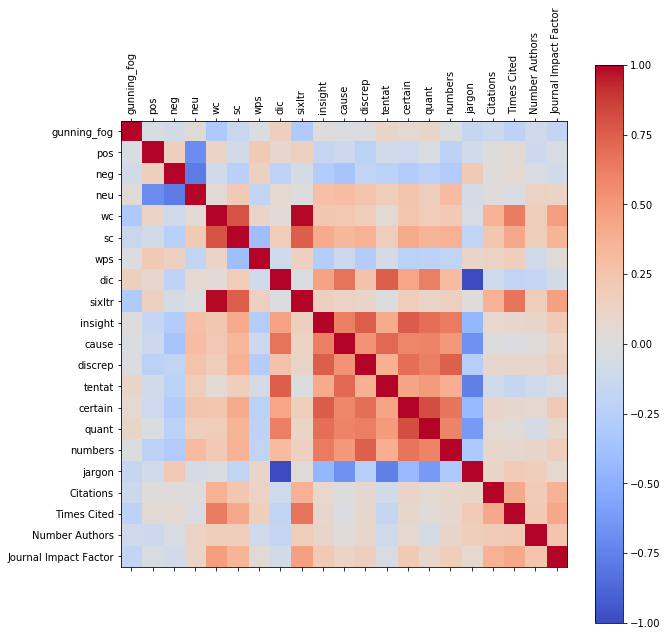

In [102]:
corr_matrix = plt_corr_matrix(features)

In [104]:
# Examine LIWC categories
liwc = ['insight', 'cause', 'discrep','tentat', 'certain', 'quant', 'numbers', 'jargon']
new_data = data.copy()
new_data[liwc] *= 100
graph_df = new_data.groupby('Retracted', as_index=True)[liwc].mean().transpose()

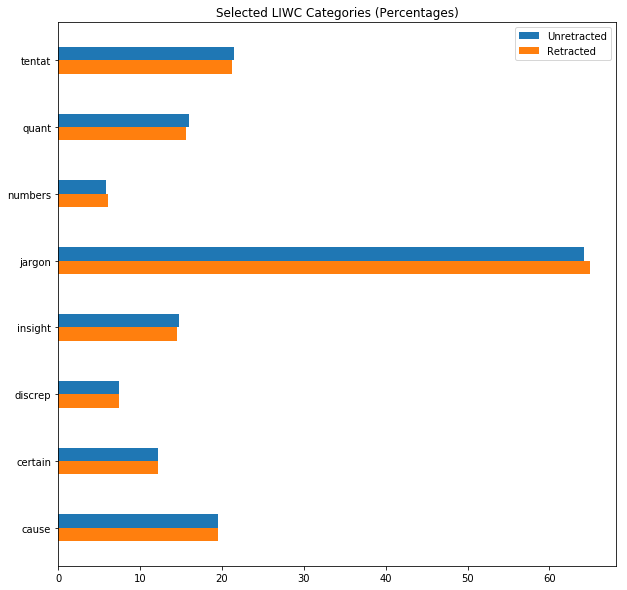

In [106]:
width = 0.2
plt.figure(figsize=(10,10))

plt.barh(graph_df.index, graph_df[graph_df.columns[0]], width, label='Unretracted', align='edge')
plt.barh(graph_df.index, graph_df[graph_df.columns[1]], -width, label='Retracted', align='edge')
plt.title('Selected LIWC Categories (Percentages)')
plt.legend(loc='best')
plt.show()

### Model exploration
We want to see how different models can handle our classification task.

In [ ]:
h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Linear SVC", "SGD"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearSVC(),
    SGDClassifier(max_iter=1000,shuffle=True)]

X = data[features]
y = data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=41)

for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)    
    print("{} -- {}".format(score, name))
    y_pred = clf.predict(X_test)
    con_matrix = confusion_matrix(Y_test, y_pred)
    # Uncomment for confusion matrix plot
    # plt.matshow(con_matrix)
    # plt.title('Confusion matrix')
    # plt.colorbar()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.show()

### Model selection: AdaBoost Classifier

In [84]:
clf = AdaBoostClassifier()
name = 'Ada Boost'
X = data[features]
y = data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=41)

clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)    
print("{} -- {}".format(score, name))
y_pred = clf.predict(X_test)
con_matrix = confusion_matrix(Y_test, y_pred)

/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5724770642201835 -- Ada Boost


0.5848623853211009


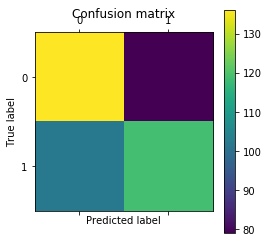

In [85]:
# Using only textual data with AdaBoost
X = data['clean_text']
y = data.Retracted

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


sgd = Pipeline([('vect', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, Y_train)

score = sgd.score(X_test, Y_test)
print(score)
y_pred = sgd.predict(X_test)
con_matrix = confusion_matrix(Y_test, y_pred)
plt.matshow(con_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Ranking Features with Recursive Feature Elimination
We want to see how important each feature is by giving each one a ranking using our chosen model: AdaBoost.

In [90]:
X = data[features]
y = data[target]
# Using AdaBoost classifier
estimator = clf
selector = RFE(estimator, n_features_to_select=10, step=1)

selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False  True  True  True False False False  True False
  True  True  True False  True  True  True False False]
[ 9  7 12 11  1  1  1 10  4  2  1  3  1  1  1  6  1  1  1  5  8]


In [91]:
# Mask of selected features
mask = selector.support_
selected = []
for feat, mask_val in zip(features, mask):
    if mask_val:
        selected.append(feat)
selected

['wc',
 'sc',
 'wps',
 'cause',
 'tentat',
 'certain',
 'quant',
 'jargon',
 'Citations',
 'Times Cited']

In [101]:
ranks = selector.ranking_
rankings = list(zip(features, ranks))
sorted_rankings = sorted(rankings, key=lambda t: t[1])
for feat, rank in sorted_rankings:
    print('Rank:', rank, feat)

Rank: 1 wc
Rank: 1 sc
Rank: 1 wps
Rank: 1 cause
Rank: 1 tentat
Rank: 1 certain
Rank: 1 quant
Rank: 1 jargon
Rank: 1 Citations
Rank: 1 Times Cited
Rank: 2 insight
Rank: 3 discrep
Rank: 4 sixltr
Rank: 5 Number Authors
Rank: 6 numbers
Rank: 7 pos
Rank: 8 Journal Impact Factor
Rank: 9 gunning_fog
Rank: 10 dic
Rank: 11 neu
Rank: 12 neg
